# Le PIB est-il un indicateur robuste de l'accès à l'alimentation ?

In [1]:
pip install faostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Partie 1 : Collecte des données

Expliquer le but de cette partie

### Récupération des données de PIB à partir de la base de données de la banque mondiale

Les données de PIB/hab de la banque mondiale sont disponibles via des pages HTML. Ici, les données utilisées correspondent au PIB/hab en $ US constant de 2015.

In [3]:
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.KD?format=json&per_page=20000"


response = requests.get(url)

# Extraction du JSON de la réponse
data = response.json()  # ici c’est correct

# Vérification des données
print(type(data),len(data))
print(data[0]) # Métadonnées
print(data[1][:5]) # Données de PIB par pays

data = data[1]  # On ne garde pas les métadonnées



<class 'list'> 2
{'page': 1, 'pages': 1, 'per_page': 20000, 'total': 17290, 'sourceid': '2', 'lastupdated': '2025-12-19'}
[{'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2024', 'value': 1435.35627774336, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2023', 'value': 1431.72178996886, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2022', 'value': 1440.43036630175, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 

#### Mise en forme des données

Pour commencer, le JSON est transformé en DataFrame et seules les données de PIB/hab pour chaque année et chaque pays sont gardées

In [4]:
from import_worldbank import parse_worldbank_pib

In [5]:
data_worldbank = parse_worldbank_pib(data)
print(data_worldbank.head(10))

                          Pays  Année       Valeur
0  Africa Eastern and Southern   2024  1435.356278
1  Africa Eastern and Southern   2023  1431.721790
2  Africa Eastern and Southern   2022  1440.430366
3  Africa Eastern and Southern   2021  1425.209057
4  Africa Eastern and Southern   2020  1399.398498
5  Africa Eastern and Southern   2019  1479.372387
6  Africa Eastern and Southern   2018  1489.942137
7  Africa Eastern and Southern   2017  1490.911098
8  Africa Eastern and Southern   2016  1490.907546
9  Africa Eastern and Southern   2015  1498.875240


Pour continuer, sont conservées uniquement les années de 2000 à 2020.

In [6]:
from import_worldbank import filter_years

In [7]:
data_worldbank = filter_years(data_worldbank,2000,2020)
print(data_worldbank.head(10))

                           Pays  Année       Valeur
4   Africa Eastern and Southern   2020  1399.398498
5   Africa Eastern and Southern   2019  1479.372387
6   Africa Eastern and Southern   2018  1489.942137
7   Africa Eastern and Southern   2017  1490.911098
8   Africa Eastern and Southern   2016  1490.907546
9   Africa Eastern and Southern   2015  1498.875240
10  Africa Eastern and Southern   2014  1495.955574
11  Africa Eastern and Southern   2013  1478.977977
12  Africa Eastern and Southern   2012  1456.722813
13  Africa Eastern and Southern   2011  1468.630572


Les données sont restreintes aux BRICSAM. 

In [8]:
from import_worldbank import filter_bricsam_countries

In [9]:
pays_a_conserver = [
        'India', 'China', 'Brazil', 'South Africa', 
        'Russian Federation', 'Mexico'
    ]

data_worldbank = filter_bricsam_countries(data_worldbank, pays_a_conserver)

# Vérifier le résultat
print(data_worldbank['Pays'].unique())
print(data_worldbank.head(10))

['Brazil' 'China' 'India' 'Mexico' 'Russian Federation' 'South Africa']
        Pays  Année       Valeur
4879  Brazil   2020  8435.010462
4880  Brazil   2019  8771.439504
4881  Brazil   2018  8722.335300
4882  Brazil   2017  8628.252096
4883  Brazil   2016  8577.842780
4884  Brazil   2015  8936.195589
4885  Brazil   2014  9338.341708
4886  Brazil   2013  9366.738247
4887  Brazil   2012  9167.498185
4888  Brazil   2011  9067.992120


Il faut ensuite vérifier s'il y a des valeurs manquantes dans les données. Ici, ce n'est pas le cas.

In [10]:
for pays in data_worldbank['Pays'].unique() :
    print(data_worldbank.loc[data_worldbank['Pays'] == pays].isna().sum(),pays)

Pays      0
Année     0
Valeur    0
dtype: int64 Brazil
Pays      0
Année     0
Valeur    0
dtype: int64 China
Pays      0
Année     0
Valeur    0
dtype: int64 India
Pays      0
Année     0
Valeur    0
dtype: int64 Mexico
Pays      0
Année     0
Valeur    0
dtype: int64 Russian Federation
Pays      0
Année     0
Valeur    0
dtype: int64 South Africa


### Récupération des données d'indicateurs d'accès à l'alimentation à partir de la base de données FAOSTAT

Les données disponibles sur le site FAOSTAT vont être récupérées et mises en forme en passant par l'API associé (bibliothèque **faostat**). Pour cela, les fonctions définies dans le fichier **import_faostat** sont utilisées. 

In [11]:
import faostat

df = faostat.list_datasets_df() # cette fonction permet de récupérer l'ensemble des indicateurs disponible
                                # ainsi que d'avoir des informations sur les màj de versions, etc.
print(df)

   code                              label date_update     note_update  \
0   QCL       Crops and livestock products  2025-06-11  minor revision   
1    QI                 Production Indices  2025-02-03                   
2    QV   Value of Agricultural Production  2025-02-03                   
3    FS  Suite of Food Security Indicators  2025-07-28                   
4   FBS              Food Balances (2010-)  2025-10-28                   
..  ...                                ...         ...             ...   
63   FA           Food Aid Shipments (WFP)  2016-12-22                   
64   RM                          Machinery  2021-12-03  minor revision   
65   RY                  Machinery Archive  2021-12-03  minor revision   
66   RA                Fertilizers archive  2020-09-08  minor revision   
67   PA       Producer Prices (old series)  1991-12-31                   

            release_current state_current year_current release_next  \
0   2024-12-20 / 2025-06-11         fina

#### Mise en forme des données

Les données utilisées couvrent la période 2000 à 2020 pour les BRICSAM. Trois indicateurs liés à la sécurité alimentaire vont être utilisés : **suffisance des apports énergétiques alimentaires moyens**, **disponibilité alimentaire par habitant**, **disponibilité protéiques moyenne**.




In [12]:
from import_fao import fetch_fao_security_data

In [13]:

liste_pays = [202,185,138,100,351,21] # Correspond aux codes des pays des BRICSAM
liste_indicateurs = ['21010','22000','21013'] # Correspond aux codes des indicateurs d'insécurité alimentaire
liste_années = [2000,2020] # Correspond à la page de dates.

data_faostat = fetch_fao_security_data(liste_pays, liste_indicateurs, liste_années)

print(data_faostat.head(10))


  Domain Code                             Domain  Area Code    Area  \
0          FS  Suite of Food Security Indicators         21  Brazil   
1          FS  Suite of Food Security Indicators         21  Brazil   
2          FS  Suite of Food Security Indicators         21  Brazil   
3          FS  Suite of Food Security Indicators         21  Brazil   
4          FS  Suite of Food Security Indicators         21  Brazil   
5          FS  Suite of Food Security Indicators         21  Brazil   
6          FS  Suite of Food Security Indicators         21  Brazil   
7          FS  Suite of Food Security Indicators         21  Brazil   
8          FS  Suite of Food Security Indicators         21  Brazil   
9          FS  Suite of Food Security Indicators         21  Brazil   

   Element Code Element  Item Code  \
0          6121   Value      21010   
1          6121   Value      21010   
2          6121   Value      21010   
3          6121   Value      21010   
4          6121   Value     

Il faut ensuite vérifier s'il y a des valeurs manquantes dans les données. Ici, ce n'est pas le cas.

In [14]:
print(data_faostat.isna().sum())

Domain Code     0
Domain          0
Area Code       0
Area            0
Element Code    0
Element         0
Item Code       0
Item            0
Year Code       0
Year            0
Unit            0
Value           0
dtype: int64


Une fois les données récupérées et après avoir vérifié qu'il n'y avait pas de valeurs manquantes, il faut ensuite les mettre en forme.

Premièrement, les colonnes inutiles sont supprimées et les autres sont renommées.


In [15]:
from import_fao import clean_fao_columns

In [16]:
data_faostat = clean_fao_columns(data_faostat)
print(data_faostat.head(10))


     Pays                                         Indicateur      Année Unité  \
0  Brazil  Average dietary energy supply adequacy (percen...  2000-2002     %   
1  Brazil  Average dietary energy supply adequacy (percen...  2001-2003     %   
2  Brazil  Average dietary energy supply adequacy (percen...  2002-2004     %   
3  Brazil  Average dietary energy supply adequacy (percen...  2003-2005     %   
4  Brazil  Average dietary energy supply adequacy (percen...  2004-2006     %   
5  Brazil  Average dietary energy supply adequacy (percen...  2005-2007     %   
6  Brazil  Average dietary energy supply adequacy (percen...  2006-2008     %   
7  Brazil  Average dietary energy supply adequacy (percen...  2007-2009     %   
8  Brazil  Average dietary energy supply adequacy (percen...  2008-2010     %   
9  Brazil  Average dietary energy supply adequacy (percen...  2009-2011     %   

   Valeur  
0   122.0  
1   124.0  
2   127.0  
3   129.0  
4   130.0  
5   131.0  
6   132.0  
7   133.0  


Le nom des indicateurs sont traduits en français pour faciliter les manipulations par la suite.

In [17]:
from import_fao import translate_indicators

In [18]:
data_faostat = translate_indicators(data_faostat)
print(data_faostat.head(10))


     Pays                                         Indicateur      Année Unité  \
0  Brazil  suffisance des apports énergétiques alimentair...  2000-2002     %   
1  Brazil  suffisance des apports énergétiques alimentair...  2001-2003     %   
2  Brazil  suffisance des apports énergétiques alimentair...  2002-2004     %   
3  Brazil  suffisance des apports énergétiques alimentair...  2003-2005     %   
4  Brazil  suffisance des apports énergétiques alimentair...  2004-2006     %   
5  Brazil  suffisance des apports énergétiques alimentair...  2005-2007     %   
6  Brazil  suffisance des apports énergétiques alimentair...  2006-2008     %   
7  Brazil  suffisance des apports énergétiques alimentair...  2007-2009     %   
8  Brazil  suffisance des apports énergétiques alimentair...  2008-2010     %   
9  Brazil  suffisance des apports énergétiques alimentair...  2009-2011     %   

   Valeur  
0   122.0  
1   124.0  
2   127.0  
3   129.0  
4   130.0  
5   131.0  
6   132.0  
7   133.0  


Les indicateurs de sécurité alimentaire importés ont été moyennés sur 3 ans. Les données sont donc disponibles par période de 3 ans (2000-2002, 2001-2003, etc.).<br><br>
Afin d'analyser les données avec celles de PIB/hab, le choix a été fait de faire correspondre chaque moyenne triennale à la première année de chaque période. Ainsi, la moyenne pour la période 2000-2002 correspond maintenant à l'année 2000.<br><br>
Cela permet de maintenir la cohérence des tendances. Toutefois, si le PIB/hab subit un choc au cours d'une année, le potentiel effet sur les indicateurs de sécurité alimentaire peut être atténué. Il faudra prendre cela en compte lors de l'analyse des résultats.


In [19]:
from import_fao import simplify_fao_years

ImportError: cannot import name 'simplify_fao_years' from 'import_fao' (/home/onyxia/work/projet_py4ds_Reis_Crapsky/import_fao.py)

In [ ]:
data_faostat = simplify_fao_years(data_faostat)
print(data_faostat.head(10))


     Pays                                         Indicateur  Année Unité  \
0  Brazil  suffisance des apports énergétiques alimentair...   2000     %   
1  Brazil  suffisance des apports énergétiques alimentair...   2001     %   
2  Brazil  suffisance des apports énergétiques alimentair...   2002     %   
3  Brazil  suffisance des apports énergétiques alimentair...   2003     %   
4  Brazil  suffisance des apports énergétiques alimentair...   2004     %   
5  Brazil  suffisance des apports énergétiques alimentair...   2005     %   
6  Brazil  suffisance des apports énergétiques alimentair...   2006     %   
7  Brazil  suffisance des apports énergétiques alimentair...   2007     %   
8  Brazil  suffisance des apports énergétiques alimentair...   2008     %   
9  Brazil  suffisance des apports énergétiques alimentair...   2009     %   

   Valeur  
0   122.0  
1   124.0  
2   127.0  
3   129.0  
4   130.0  
5   131.0  
6   132.0  
7   133.0  
8   134.0  
9   136.0  


Lors de l'import des données, il se trouve que la sélection des années n'a pas été faites. Cela est lié à un problème sur la construction des années dans le jeu de données. Par défaut, l'ensemble des années a donc été importé. <br><br>Malgré plusieurs tentatives, il n'a pas été possible de trouver comment résoudre ce problème. Finalement, le plus aisé est de supprimer les années en trop (2021 et 2022) une fois la mise en forme des données effectuée. 

In [ ]:
# On garde toutes les lignes sauf celles où l'année est 2021 ou 2022
data_faostat = data_faostat[~data_faostat['Année'].isin([2021, 2022])]
print(data_faostat.head(22))


      Pays                                         Indicateur  Année  \
0   Brazil  suffisance des apports énergétiques alimentair...   2000   
1   Brazil  suffisance des apports énergétiques alimentair...   2001   
2   Brazil  suffisance des apports énergétiques alimentair...   2002   
3   Brazil  suffisance des apports énergétiques alimentair...   2003   
4   Brazil  suffisance des apports énergétiques alimentair...   2004   
5   Brazil  suffisance des apports énergétiques alimentair...   2005   
6   Brazil  suffisance des apports énergétiques alimentair...   2006   
7   Brazil  suffisance des apports énergétiques alimentair...   2007   
8   Brazil  suffisance des apports énergétiques alimentair...   2008   
9   Brazil  suffisance des apports énergétiques alimentair...   2009   
10  Brazil  suffisance des apports énergétiques alimentair...   2010   
11  Brazil  suffisance des apports énergétiques alimentair...   2011   
12  Brazil  suffisance des apports énergétiques alimentair...   

### Création du jeu de données final

une fois mises en forme, il est possible de concaténer les deux jeux de données puis de les exporter en un fichier csv.<br><br> Avant cela il faut modifier le jeu de données **worldbank** pour le mettre au même format que le jeu **faostat**.

In [ ]:
def format_data_worldbank(data):
    """
    Harmonise le dataframe World Bank pour qu'il ait la même structure que FAOSTAT.
    """
    
    # 1. Ajouter les colonnes manquantes avec les valeurs fixes demandées
    data['Indicateur'] = "PIB par habitant"
    data['Unité'] = "$"
    
    # 2. Réorganiser l'ordre des colonnes pour qu'il soit identique à FAOSTAT
    return data[['Pays', 'Indicateur', 'Unité', 'Année', 'Valeur']]

In [ ]:
# 1. On formate les données World Bank
data_worldbank_formatted = format_data_worldbank(data_worldbank)

# 2. On concatène les deux DataFrames
data_BRICSAM = pd.concat([data_faostat, data_worldbank_formatted], ignore_index=True)

# 3. On trie le dataframe et on réinitialise l'index
data_BRICSAM = data_BRICSAM.sort_values(by=['Pays', 'Indicateur', 'Année'])
data_BRICSAM = data_BRICSAM.reset_index(drop=True)

# 4. On exporte en CSV
data_BRICSAM.to_csv("données_BRICSAM.csv")

print(data_BRICSAM.head(10))

     Pays        Indicateur  Année Unité       Valeur
0  Brazil  PIB par habitant   2000     $  6817.783456
1  Brazil  PIB par habitant   2001     $  6823.033185
2  Brazil  PIB par habitant   2002     $  6944.622576
3  Brazil  PIB par habitant   2003     $  6941.439659
4  Brazil  PIB par habitant   2004     $  7258.781017
5  Brazil  PIB par habitant   2005     $  7409.568280
6  Brazil  PIB par habitant   2006     $  7622.039194
7  Brazil  PIB par habitant   2007     $  8003.253210
8  Brazil  PIB par habitant   2008     $  8330.763640
9  Brazil  PIB par habitant   2009     $  8246.096121


La dernière étape consiste à modifier le dataframe complet pour que les indicateurs passent en colonne.

In [ ]:
def pivot_bricsam_data(df):
    """
    Transforme le dataframe pour mettre chaque indicateur en colonne 
    avec son unité intégrée dans le nom.
    """
    # 1. On crée le nouveau nom de colonne : "Indicateur (Unité)"
    df['Indicateur_Unite'] = df['Indicateur'] + " (" + df['Unité'] + ")"
    
    # 2. On pivote le tableau
    df_pivot = df.pivot(index=['Pays', 'Année'], 
                        columns='Indicateur_Unite', 
                        values='Valeur').reset_index()
    
    # 3. On trie par Pays et Année
    df_pivot = df_pivot.sort_values(by=['Pays', 'Année'])
    
    return df_pivot



In [ ]:
# 1. On effectue le pivotage du dataframe
data_BRICSAM_pivot = pivot_bricsam_data(data_BRICSAM)

# 2. On exporte les données
data_BRICSAM_pivot.to_csv("données_BRICSAM_pivot.csv")


### Visualisation du jeu de données final

In [ ]:
data_BRICSAM_pivot.head(10)

Indicateur_Unite,Pays,Année,PIB par habitant ($),disponibilité alimentaire par habitant (kcal/cap/d),disponibilité protéiques moyenne (g/cap/d),suffisance des apports énergétiques alimentaires moyens (%)
0,Brazil,2000,6817.783456,2896.0,80.2,122.0
1,Brazil,2001,6823.033185,2960.0,81.8,124.0
2,Brazil,2002,6944.622576,3031.0,83.2,127.0
3,Brazil,2003,6941.439659,3100.0,83.8,129.0
4,Brazil,2004,7258.781017,3133.0,83.7,130.0
5,Brazil,2005,7409.568280,3167.0,84.2,131.0
6,Brazil,2006,7622.039194,3201.0,86.1,132.0
7,Brazil,2007,8003.253210,3235.0,87.5,133.0
8,Brazil,2008,8330.763640,3269.0,92.5,134.0
9,Brazil,2009,8246.096121,3307.0,97.0,136.0


## Partie 2 : DATA VISUALIZATION

### Evolutions graphiques

In [ ]:
from data_viz import graph_evol

In [ ]:
indicators = [
    'PIB par habitant ($)',
    'disponibilité alimentaire par habitant (kcal/cap/d)',
    'disponibilité protéiques moyenne (g/cap/d)',
    'suffisance des apports énergétiques alimentaires moyens (%)'
            ]

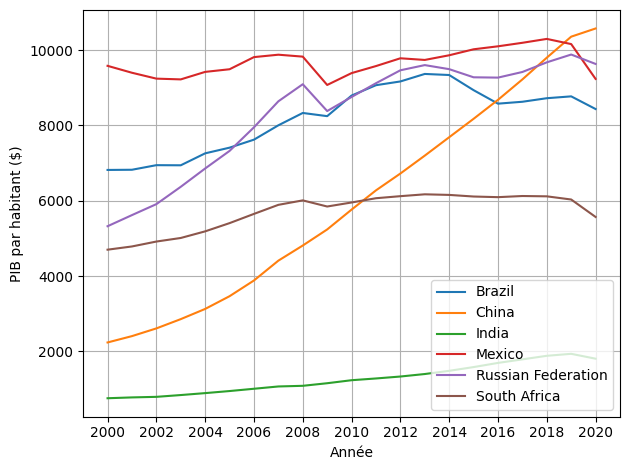

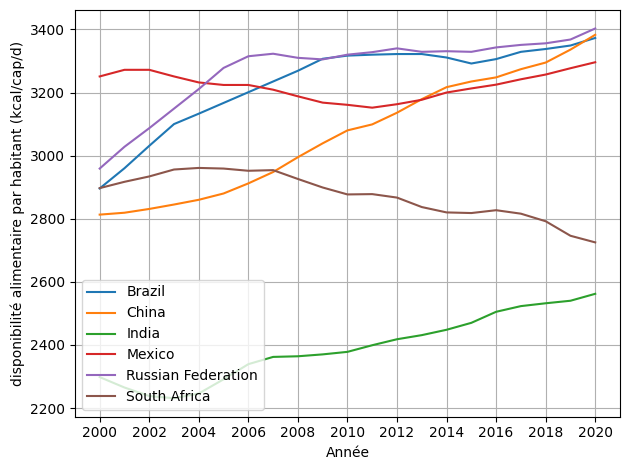

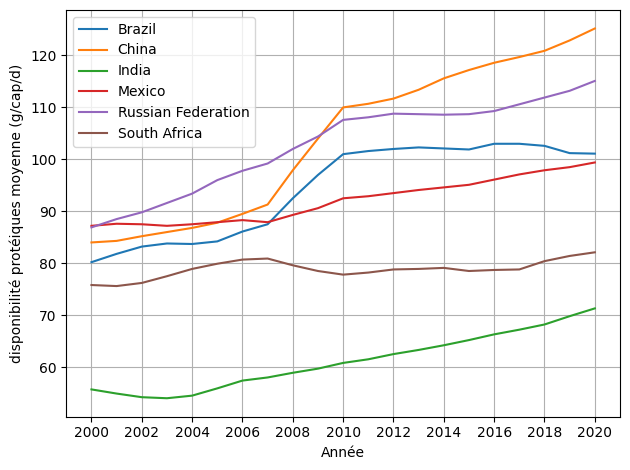

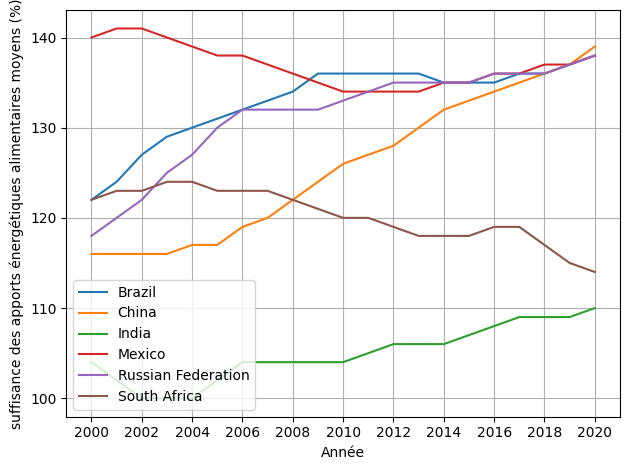

In [ ]:
for indicator in indicators :
    graph_evol(data_BRICSAM_pivot, indicator)

## Partie 3 : MODELE

In [ ]:
data_BRICSAM_pivot.head(10)

Indicateur_Unite,Pays,Année,PIB par habitant ($),disponibilité alimentaire par habitant (kcal/cap/d),disponibilité protéiques moyenne (g/cap/d),suffisance des apports énergétiques alimentaires moyens (%)
0,Brazil,2000,6817.783456,2896.0,80.2,122.0
1,Brazil,2001,6823.033185,2960.0,81.8,124.0
2,Brazil,2002,6944.622576,3031.0,83.2,127.0
3,Brazil,2003,6941.439659,3100.0,83.8,129.0
4,Brazil,2004,7258.781017,3133.0,83.7,130.0
5,Brazil,2005,7409.568280,3167.0,84.2,131.0
6,Brazil,2006,7622.039194,3201.0,86.1,132.0
7,Brazil,2007,8003.253210,3235.0,87.5,133.0
8,Brazil,2008,8330.763640,3269.0,92.5,134.0
9,Brazil,2009,8246.096121,3307.0,97.0,136.0


### ACP

### Régression(s) linéaire PIB/hab

### Régression(s) linéaire IDH